# Préparation du référentiel géographique

Ce module constitue la **fondation structurelle** du projet. Il assure la configuration technique et la préparation du référentiel parcellaire qui servira de support unique à l'ensemble des analyses thématiques.

## 1. Initialisation et paramétrage
* **Mode d'exécution** : Variable `DALLE_SELECTION` permettant de basculer entre un traitement localisé (une dalle) ou global (tout le territoire).
* **Nomenclature cible** : Standardisation vers **6 classes** (`ARTIFICIALISE`, `AGRICULTURE`, `NATURE`, `BOIS`, `EAU`, `AUTRE`) pour harmoniser les sources disparates.
* **Gestion des chemins** : Utilisation de `pathlib` pour garantir la compatibilité des accès fichiers entre différents environnements.

## 2. Flux de traitement du parcellaire
La logique de construction repose sur quatre étapes clés :

1. **Définition du masque spatial** : Chargement de la couche de zone pour délimiter le périmètre de calcul.
2. **Extraction optimisée** : Chargement du cadastre en utilisant l'emprise comme **masque de lecture** (`mask`) pour réduire la charge mémoire.
3. **Indexation territoriale** : Jointure spatiale (`sjoin`) pour lier chaque parcelle à son entité administrative ou technique (Dalle).
4. **Création de l'identifiant unique `PL`** : Génération d'une clé primaire normalisée :
   * **Format** : `Département (2) + Commune (3) + Section (2) + Numéro (4)`
   * **Exemple** : `67001AA0042`

## 3. Sécurisation des Données
* **Normalisation** : Utilisation de `.zfill()` pour garantir une longueur fixe des identifiants (prévention des erreurs de jointure).
* **Déduplication** : Suppression des doublons géométriques résultant des intersections spatiales.
* **Moteur de lecture** : Utilisation de `pyogrio` pour une lecture vectorielle haute performance.

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path

# =============================================================================
# MODULE 1 : INITIALISATION DE L'ENVIRONNEMENT ET CHARGEMENT DU RÉFÉRENTIEL
# =============================================================================

# --- 1. PARAMÉTRAGE DE L'EXÉCUTION ---
# Passage en mode traitement global : toutes les entités de la couche ZONE seront traitées.
DALLE_SELECTION = None 

# --- 2. CONFIGURATION DE L'ARBORESCENCE ---
DIR_ENTREE_SIG   = Path(r'C:/Users/liege/Desktop/GEOLAB/ENTRER')
DIR_ENTREE_NOMEN = Path(r'C:/Users/liege/Desktop/GEOLAB/NOMENCLATURE')
DIR_SORTIE       = Path(r'C:/Users/liege/Desktop/GEOLAB/SORTIE/COMPARATIF_2021')

# Création du répertoire de sortie si inexistant
DIR_SORTIE.mkdir(parents=True, exist_ok=True)

# --- 3. DICTIONNAIRE DE CONFIGURATION ---
config = {
    # Clés composites d'identification parcellaire
    'CHAMPS_ID': ["CODE_DEP", "NOM_COM", "CODE_COM", "SECTION", "NUMERO", "DALLE"],
    
    # Nomenclature cible normalisée (6 postes)
    'CLASSES': ["ARTIFICIALISE", "AGRICULTURE", "NATURE", "BOIS", "EAU", "AUTRE"],
    
    # Chemins des référentiels structurels
    'ZONE_PATH'     : DIR_ENTREE_SIG / "ZONE.gpkg",
    'CADASTRE_PATH' : DIR_ENTREE_SIG / "CADASTRE.gpkg",
    
    # --- SOURCES THÉMATIQUES (MILLESIME 2021) ---
    'OSO_GPKG'       : DIR_ENTREE_SIG / "OSO_2018_2023_ALL.gpkg",
    'OSO_LAYER'      : "OSO_VECTEUR_2021",
    'NOMEN_OSO'      : DIR_ENTREE_NOMEN / "Nomenclature_OSO.csv",
    
    'RPG_GPKG'       : DIR_ENTREE_SIG / "RPG_2018_2024_ALL.gpkg",
    'RPG_LAYER'      : "RPG_2021",
    'RPG_COMP_GPKG'  : DIR_ENTREE_SIG / "RPG_COMPLETE_2018_2022_ALL.gpkg",
    'RPG_COMP_LAYER' : "RPG_COMPLETE_2021",
    
    'COSIA_GPKG'     : DIR_ENTREE_SIG / "COSIA_2018_2024_ALL.gpkg",
    'COSIA_LAYER'    : "COSIA_VECTEUR_2021",
    'NOMEN_COSIA'    : DIR_ENTREE_NOMEN / "Nomenclature_COSIA.csv",

    'FORET_PATH'     : DIR_ENTREE_SIG / "FORMATION_VEGETALE_BD_FORET_2017.gpkg",
    
    'BDTOPO_PATH'    : DIR_ENTREE_SIG / "BDTOPO_2021.gpkg",
}

print(">>> INITIALISATION : Environnement chargé.")
print(f"    Sortie : {DIR_SORTIE}")
print(f"    Mode   : {'Traitement complet (Toutes dalles)' if not DALLE_SELECTION else 'Dalle unique (' + DALLE_SELECTION + ')'}")

# =============================================================================
# TRAITEMENT DU RÉFÉRENTIEL FONCIER
# =============================================================================
print("\n>>> CHARGEMENT DU PARCELLAIRE...")

try:
    # 1. Chargement de l'emprise géographique globale
    gdf_zone = gpd.read_file(config['ZONE_PATH'])
    
    # Filtrage conditionnel si une dalle spécifique est demandée
    if DALLE_SELECTION:
        gdf_zone['DALLE'] = gdf_zone['DALLE'].astype(str)
        gdf_zone = gdf_zone[gdf_zone['DALLE'] == str(DALLE_SELECTION)]
        
        if gdf_zone.empty:
            raise ValueError(f"Erreur : Dalle {DALLE_SELECTION} inexistante dans le fichier ZONE.")

    print(f"    Emprise définie : {len(gdf_zone)} entité(s) de zone chargée(s).")

    # 2. Extraction du cadastre (Utilisation de l'emprise globale comme masque spatial)
    gdf_parcelles = gpd.read_file(
        config['CADASTRE_PATH'], 
        mask=gdf_zone, 
        engine='pyogrio'
    )
    
    # 3. Attribution des identifiants de zone aux parcelles (Jointure spatiale)
    gdf_parcelles = gpd.sjoin(
        gdf_parcelles, 
        gdf_zone[['DALLE', 'geometry']], 
        how='inner', 
        predicate='intersects'
    )
    
    if 'index_right' in gdf_parcelles.columns: 
        gdf_parcelles = gdf_parcelles.drop(columns='index_right')

    # 4. Génération de l'Identifiant Parcellaire Unique (PL)
    gdf_parcelles['PL'] = (
        gdf_parcelles['CODE_DEP'].astype(str).str.zfill(2) + 
        gdf_parcelles['CODE_COM'].astype(str).str.zfill(3) + 
        gdf_parcelles['SECTION'].astype(str).str.zfill(2) + 
        gdf_parcelles['NUMERO'].astype(str).str.zfill(4)
    )

    # Suppression des doublons potentiels suite à la jointure spatiale sur emprise globale
    gdf_parcelles = gdf_parcelles.drop_duplicates(subset=['PL'])

    print(f"    Référentiel parcellaire chargé : {len(gdf_parcelles)} enregistrements uniques.")
    
except Exception as e:
    print(f"ERREUR CRITIQUE (Module 1) : {e}")

>>> INITIALISATION : Environnement chargé.
    Sortie : C:\Users\liege\Desktop\GEOLAB\SORTIE\COMPARATIF_2021
    Mode   : Traitement complet (Toutes dalles)

>>> CHARGEMENT DU PARCELLAIRE...
    Emprise définie : 5 entité(s) de zone chargée(s).
    Référentiel parcellaire chargé : 6792 enregistrements uniques.


# Traitement de l'cccupation du sol (OSO 2021)

Ce module traite les données de la couche **OSO (Theia)** pour le millésime 2021. Son objectif est de ventiler spatialement les classes d'occupation du sol à l'échelle de la parcelle et de calculer des indices de confiance associés.

## 1. Harmonisation de la nomenclature
Le script réalise une passerelle entre la nomenclature détaillée OSO et la nomenclature cible du projet.
* **Mapping thématique** : Conversion des codes sources vers les **6 classes cibles** (`ARTIFICIALISE`, `AGRICULTURE`, `BOIS`, `NATURE`, `EAU`, `AUTRE`).
* **Initialisation** : Chargement automatique des fichiers de correspondance CSV pour assurer la reproductibilité.

## 2. Flux de traitement spatial
La logique repose sur une intersection géométrique précise pour découper les polygones OSO par les limites cadastrales.

1. **Chargement masqué** : Lecture de la couche OSO avec un filtre spatial basé sur le référentiel parcellaire (gain de performance).
2. **Reprojection (CRS)** : Harmonisation automatique des systèmes de coordonnées si nécessaire.
3. **Intersection (`overlay`)** : Découpage géométrique des entités OSO par parcelle (`PL`).
   - Calcul de la surface de chaque fragment (`S_INT`).
   - Extraction de l'indice de confiance (confidence score) natif de la donnée OSO.

## 3. Agrégation et indicateurs statistiques
Pour chaque unité foncière, le script compile les fragments d'occupation du sol pour générer deux indicateurs clés par classe :

* **Ratio surfacique (`%`)** : Proportion de la surface de la parcelle occupée par la classe donnée (ex: 80% AGRICULTURE).
* **Indice de probabilité (`PROBA`)** : Moyenne du score de confiance OSO, pondérée par la surface d'occupation au sein de la parcelle.

In [2]:
# =============================================================================
# MODULE 2 : TRAITEMENT DE L'OCCUPATION DU SOL (OSO - MILLÉSIME 2021)
# =============================================================================
import pandas as pd
import geopandas as gpd
from pathlib import Path

print("\n>>> DÉMARRAGE MODULE 2 : ANALYSE OSO 2021...")

# --- 1. INITIALISATION DES RÉFÉRENTIELS DE NOMENCLATURE ---
try:
    df_nomen = pd.read_csv(config['NOMEN_OSO'], sep=';', encoding='utf-8-sig')
    
    # Mapping des classes OSO vers la nomenclature cible (6 classes)
    noms_classes_map = {
        "1": "ARTIFICIALISE", 
        "2": "AGRICULTURE", 
        "4": "NATURE", 
        "3": "BOIS", 
        "5": "EAU", 
        "0": "AUTRE"
    }

    mapping_oso = {
        str(row['CODE_SOURCE']).strip(): noms_classes_map.get(str(row['CLASSE_6']).strip(), "AUTRE") 
        for _, row in df_nomen.iterrows()
    }

    # --- 2. TRAITEMENT SPATIAL ET INTERSECTION ---
    # Chargement de la couche OSO avec masque spatial sur le référentiel parcellaire complet
    lyr_oso = gpd.read_file(
        config['OSO_GPKG'], 
        layer=config['OSO_LAYER'], 
        mask=gdf_parcelles, 
        engine='pyogrio'
    )
    
    if not lyr_oso.empty:
        # Harmonisation du système de coordonnées (CRS)
        if lyr_oso.crs != gdf_parcelles.crs: 
            lyr_oso = lyr_oso.to_crs(gdf_parcelles.crs)
        
        # Intersection géométrique pour découpage à la parcelle
        inter = gpd.overlay(lyr_oso, gdf_parcelles[['PL', 'geometry']], how='intersection')
        inter['S_INT'] = inter.geometry.area
        
        # --- 3. QUALIFICATION DES ENTITÉS (CLASSE ET CONFIANCE) ---
        # Identification dynamique des champs de classe et de confiance
        f_classe = "Classe" if "Classe" in inter.columns else "CLASSE"
        f_conf = next((f for f in inter.columns if "confidence" in f.lower()), None)
        
        inter['CLASSE_NOM'] = inter[f_classe].astype(str).str.strip().map(mapping_oso).fillna("AUTRE")
        
        # Calcul de la confiance pondérée par la surface d'intersection
        conf_val = inter[f_conf] if f_conf else 100
        inter['CONF_POND'] = conf_val * inter['S_INT']

        # --- 4. AGRÉGATION STATISTIQUE PAR PARCELLE ---
        stats = inter.groupby(['PL', 'CLASSE_NOM']).agg({
            'S_INT': 'sum',
            'CONF_POND': 'sum'
        }).reset_index()

        # Pivotage des données pour obtenir une structure par classe en colonnes
        df_surf = stats.pivot(index='PL', columns='CLASSE_NOM', values='S_INT').fillna(0.0)
        df_conf = stats.pivot(index='PL', columns='CLASSE_NOM', values='CONF_POND').fillna(0.0)

        # --- 5. CALCUL DES INDICATEURS DE SYNTHÈSE ---
        final_oso = pd.DataFrame(index=df_surf.index)
        
        # Référence surfacique extraite du cadastre
        ref_surf = gdf_parcelles.set_index('PL').geometry.area
        surf_tot = ref_surf.loc[final_oso.index]
        
        for cl in config['CLASSES']:
            s_col = df_surf[cl] if cl in df_surf.columns else pd.Series(0.0, index=final_oso.index)
            c_col = df_conf[cl] if cl in df_conf.columns else pd.Series(0.0, index=final_oso.index)
            
            col_pct_name = f"{cl}_%"
            col_prob_name = f"{cl}_PROBA"
            
            # Calcul du ratio surfacique (%)
            mask_surf_tot = surf_tot > 0
            final_oso[col_pct_name] = 0.0
            if mask_surf_tot.any():
                final_oso.loc[mask_surf_tot, col_pct_name] = (
                    (s_col[mask_surf_tot] / surf_tot[mask_surf_tot]) * 100
                ).round(2)
            
            # Calcul de la probabilité (moyenne pondérée par la surface)
            mask_classe = s_col > 0
            final_oso[col_prob_name] = 0.0
            if mask_classe.any():
                final_oso.loc[mask_classe, col_prob_name] = (
                    c_col[mask_classe] / s_col[mask_classe]
                ).round(1)

        # --- 6. EXPORTATION DES RÉSULTATS ---
        # Définition dynamique du nom de fichier selon le mode d'exécution
        out_name = f"OSO_2021_DALLE_{DALLE_SELECTION}.csv" if DALLE_SELECTION else "OSO_2021_FULL.csv"
        final_oso.reset_index().to_csv(DIR_SORTIE / out_name, sep=';', index=False)
        print(f"    Export terminé : {out_name}")
        
    else:
        print("    Avertissement : Aucune donnée OSO intersectant le référentiel parcellaire.")

except Exception as e:
    print(f"    Erreur lors de l'exécution du Module OSO : {e}")


>>> DÉMARRAGE MODULE 2 : ANALYSE OSO 2021...
    Export terminé : OSO_2021_FULL.csv


# Analyse des formations végétales (BD FORÊT 2017)

Ce module traite les données de la **BD Forêt (IGN)** pour affiner la caractérisation des espaces boisés et naturels. Il permet de distinguer précisément les formations forestières des zones de landes au sein du référentiel parcellaire.

## 1. Prétraitement et Intersection Spatiale
Le flux de données repose sur un découpage géométrique rigoureux :
* **Chargement optimisé** : Lecture de la couche vectorielle avec un **masque spatial** sur le parcellaire pour limiter la charge mémoire.
* **Harmonisation (CRS)** : Reprojection automatique vers le système de coordonnées de référence du projet.
* **Calcul de surface** : Intersection géométrique (`overlay`) pour calculer la superficie exacte de chaque type de végétation par unité foncière (`PL`).

## 2. Classification sémantique
Les types de formations végétales (attribut `TFV`) sont reclassés selon une nomenclature simplifiée :
* **Classe NATURE** : Assignée aux formations de type "Lande" ou "Herbacée".
* **Classe BOIS** : Assignée aux autres formations forestières (forêts, bosquets, peupleraies).
* **Classe AUTRE** : Représente le reliquat de la parcelle non couvert par la donnée thématique forestière.

## 3. Indicateurs et agrégation
Pour chaque parcelle, le module génère des statistiques de synthèse :
* **Ratio surfacique (`%`)** : Part relative de chaque classe végétale par rapport à la surface cadastrale totale.
* **Indice de probabilité (`PROBA`)** : Fixé à 100% pour les classes documentées par la source, permettant de valider la présence effective de végétation.
* **Gestion du reliquat** : Calcul automatique de la surface non documentée, basculée en classe "AUTRE" pour garantir un bilan de surface à 100%.

In [3]:
# =============================================================================
# MODULE 3 : TRAITEMENT DE LA BD FORÊT (MILLÉSIME 2017)
# =============================================================================
import pandas as pd
import geopandas as gpd
from pathlib import Path

print("\n>>> DÉMARRAGE MODULE 3 : ANALYSE BD FORÊT 2017...")

try:
    # --- 1. LECTURE ET PRÉTRAITEMENT SPATIAL ---
    # Chargement de la couche vectorielle avec application d'un masque spatial
    # basé sur le référentiel parcellaire global.
    lyr_foret = gpd.read_file(
        config['FORET_PATH'], 
        layer="FORMATION_VEGETALE_BD_FORET_2017", 
        mask=gdf_parcelles, 
        engine='pyogrio'
    )
    
    if not lyr_foret.empty:
        # Harmonisation du système de coordonnées de référence (CRS)
        if lyr_foret.crs != gdf_parcelles.crs: 
            lyr_foret = lyr_foret.to_crs(gdf_parcelles.crs)
        
        # Intersection géométrique pour la segmentation des formations forestières par parcelle
        inter = gpd.overlay(lyr_foret, gdf_parcelles[['PL', 'geometry']], how='intersection')
        inter['S_INT'] = inter.geometry.area
        
        # --- 2. CLASSIFICATION SÉMANTIQUE ---
        # Application des règles de transcodage vers la nomenclature cible :
        # - Formations de type "Lande" ou "Herbacée" -> Classe NATURE
        # - Autres formations forestières (forêts, peupleraies) -> Classe BOIS
        inter['CLASSE'] = inter['TFV'].apply(
            lambda x: "NATURE" if "lande" in str(x).lower() else "BOIS"
        )
        
        # --- 3. AGRÉGATION STATISTIQUE ---
        # Groupement par identifiant parcellaire et calcul des surfaces cumulées
        stats = inter.groupby(['PL', 'CLASSE'])['S_INT'].sum().reset_index()
        piv = stats.pivot(index='PL', columns='CLASSE', values='S_INT').fillna(0.0)
        
        # --- 4. CALCUL DES INDICATEURS PAR UNITÉ FONCIÈRE ---
        res_foret = []
        
        # Itération sur l'intégralité du référentiel parcellaire chargé
        for pl in gdf_parcelles['PL']:
            # Récupération de la surface de référence cadastrale
            surf_cad = gdf_parcelles[gdf_parcelles['PL'] == pl].geometry.area.iloc[0]
            row = {'PL': pl}
            
            # Extraction des surfaces identifiées par thématique
            s_bois = piv.loc[pl, 'BOIS'] if pl in piv.index and 'BOIS' in piv.columns else 0.0
            s_nat = piv.loc[pl, 'NATURE'] if pl in piv.index and 'NATURE' in piv.columns else 0.0
            
            # Calcul de la surface résiduelle (non documentée par la source thématique)
            surf_autre = max(0, surf_cad - (s_bois + s_nat))
            
            # Calcul des indicateurs de ratio et de probabilité pour chaque classe cible
            for cl in config['CLASSES']:
                val_pct = 0.0
                val_proba = 0.0
                
                if cl == "BOIS":
                    val_pct = (s_bois / surf_cad) * 100
                    val_proba = 100.0 if s_bois > 1 else 0.0
                elif cl == "NATURE":
                    val_pct = (s_nat / surf_cad) * 100
                    val_proba = 100.0 if s_nat > 1 else 0.0
                elif cl == "AUTRE":
                    val_pct = (surf_autre / surf_cad) * 100
                    # La probabilité est nulle sur le reliquat (absence d'information thématique)
                    val_proba = 0.0 
                
                row[f"{cl}_%"] = round(val_pct, 2)
                row[f"{cl}_PROBA"] = val_proba
                
            res_foret.append(row)
            
        # --- 5. EXPORTATION DES DONNÉES ---
        df_foret = pd.DataFrame(res_foret)
        # Détermination dynamique du nom de fichier selon le périmètre de traitement
        out_name = f"FORET_2017_DALLE_{DALLE_SELECTION}.csv" if DALLE_SELECTION else "FORET_2017_FULL.csv"
        df_foret.to_csv(DIR_SORTIE / out_name, sep=';', index=False)
        print(f"    Traitement exporté : {out_name}")
        
    else:
        print("    Avertissement : Aucune entité de la BD Forêt détectée sur l'emprise étudiée.")

except Exception as e:
    print(f"    Erreur technique lors du traitement BD FORÊT : {e}")


>>> DÉMARRAGE MODULE 3 : ANALYSE BD FORÊT 2017...
    Traitement exporté : FORET_2017_FULL.csv


# Traitement du RPG (Fusion Standard et Complet 2021)

Ce module assure l'intégration des données agricoles du **RPG**. Il fusionne les versions "Standard" et "Complet" pour caractériser l'occupation agricole du sol à l'échelle de la parcelle cadastrale.

## 1. Méthodologie de reclassification
Le script harmonise les catégories de cultures vers la nomenclature cible via deux logiques distinctes :
* **RPG Standard** : Reclassification basée sur le `CODE_GROUP`. La classe **17** est basculée en **NATURE**, les autres codes en **AGRICULTURE**.
* **RPG Complet** : Analyse textuelle du libellé de culture.
    * *Exemples* : "Jardin collectif" → **ARTIFICIALISE**, "Landes" → **NATURE**, "Abandon" → **AGRICULTURE**.

## 2. Flux de traitement spatial
Le traitement est appliqué séquentiellement aux deux sources (Standard et Complet) :
1. **Intersection géométrique** : Découpage des îlots culturaux par les limites des parcelles cadastrales (`PL`).
2. **Validation topologique** : Utilisation de `make_valid()` pour garantir l'intégrité des géométries lors de l'intersection.
3. **Calcul de surface** : Mesure précise de la superficie intersectée (`S_INT`) pour chaque fragment de culture.

## 3. Gestion des indicateurs (Confiance et Ratio)
Pour chaque unité foncière, le module calcule deux métriques fondamentales :
* **Ratio surfacique (`%`)** : Pourcentage de la parcelle couvert par le RPG. Les surfaces non déclarées sont automatiquement basculées dans la classe **AUTRE** pour équilibrer le bilan à 100%.
* **Indice de probabilité (`PROBA`)** : 
    * Fixé à 100% pour le RPG Standard (donnée déclarative certifiée).
    * Calculé par moyenne pondérée par la surface pour le RPG Complet, intégrant les scores de proba natifs de la donnée.

In [4]:
# =============================================================================
# MODULE 4 : TRAITEMENT DU RPG (FUSION STANDARD ET COMPLET 2021)
# =============================================================================
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path

print("\n>>> DÉMARRAGE MODULE 4 : ANALYSE RPG 2021...")

# --- 1. FONCTION DE RECLASSIFICATION SÉMANTIQUE ---
def reclass_rpg(row, est_std):
    """
    Normalise les catégories de cultures RPG vers la nomenclature cible.
    """
    if est_std:
        # Traitement du RPG Standard via le champ CODE_GROUP
        try:
            val = row.get('CODE_GROUP', 0)
            grp = int(val) if val is not None else 0
        except (ValueError, TypeError):
            grp = 0
            
        # La catégorie 17 correspond aux prairies permanentes (NATURE)
        if grp == 17: return "NATURE"
        return "AGRICULTURE"
    else:
        # Traitement du RPG Complet via analyse textuelle du champ 'culture'
        label = str(row.get("culture", "")).lower()
        if not label or label == "none": return "AUTRE"

        # Application des règles de transcodage spécifiques
        if "jardin collectif" in label: return "ARTIFICIALISE"
        if "landes" in label: return "NATURE"
        if "landes (pelouses)" in label: return "NATURE"
        if "abandon" in label: return "AGRICULTURE"
        
        return "AGRICULTURE"

# --- 2. INITIALISATION DES ACCUMULATEURS STATISTIQUES ---
# Utilisation de dictionnaires indexés par l'identifiant parcellaire (PL)
accum_surf = {pl: {c: 0.0 for c in config['CLASSES']} for pl in gdf_parcelles['PL']}
accum_conf = {pl: {c: 0.0 for c in config['CLASSES']} for pl in gdf_parcelles['PL']}

# --- 3. PROCÉDURE DE TRAITEMENT DES SOURCES RPG ---
def process_rpg_source(path, layer, est_std):
    """
    Exécute la lecture, l'intersection spatiale et l'agrégation des données.
    """
    try:
        lyr = gpd.read_file(path, layer=layer, mask=gdf_parcelles, engine='pyogrio')
        if lyr.empty: return

        # Harmonisation du système de coordonnées (CRS)
        if lyr.crs != gdf_parcelles.crs: 
            lyr = lyr.to_crs(gdf_parcelles.crs)
        
        # Validation géométrique et intersection
        lyr['geometry'] = lyr.geometry.make_valid()
        inter = gpd.overlay(lyr, gdf_parcelles[['PL', 'geometry']], how='intersection')
        
        if inter.empty: return

        # Calcul des surfaces d'intersection et application de la reclassification
        inter['S_INT'] = inter.geometry.area
        inter['CLASSE'] = inter.apply(lambda r: reclass_rpg(r, est_std), axis=1)
        
        # Normalisation des indices de confiance (PROBA)
        if est_std:
            inter['PROBA'] = 100.0
        else:
            if 'proba' in inter.columns:
                # Conversion des probabilités décimales en pourcentages
                p_raw = inter['proba'].astype(str).str.replace(',', '.').astype(float).fillna(0.0)
                inter['PROBA'] = np.where(p_raw <= 1.0, p_raw * 100.0, p_raw)
            else:
                inter['PROBA'] = 100.0
            
        # Calcul de la probabilité pondérée par la surface
        inter['P_POND'] = inter['S_INT'] * inter['PROBA']
        
        # Agrégation dans les dictionnaires globaux
        for row in inter.itertuples():
            if row.PL in accum_surf and row.CLASSE in config['CLASSES']:
                accum_surf[row.PL][row.CLASSE] += row.S_INT
                accum_conf[row.PL][row.CLASSE] += row.P_POND
                
    except Exception as e:
        print(f"    Note technique : Source {layer} non traitée ({e})")

# --- 4. EXÉCUTION DU TRAITEMENT SÉQUENTIEL ---
process_rpg_source(config['RPG_GPKG'], config['RPG_LAYER'], True)
process_rpg_source(config['RPG_COMP_GPKG'], config['RPG_COMP_LAYER'], False)

# --- 5. CALCUL DES INDICATEURS FINAUX ET EXPORTATION ---
result_rows = []
for pl, surfs in accum_surf.items():
    row = {'PL': pl}
    # Extraction de la surface cadastrale de référence
    surf_cad = gdf_parcelles[gdf_parcelles['PL'] == pl].geometry.area.iloc[0]
    
    # Intégration du reliquat (surfaces non déclarées au RPG) dans la classe AUTRE
    total_rpg = sum(surfs.values())
    reste = max(0, surf_cad - total_rpg)
    surfs['AUTRE'] += reste
    
    # Calcul des ratios surfaciques et des probabilités moyennes par classe
    for cl in config['CLASSES']:
        s = surfs[cl]
        p_pond = accum_conf[pl][cl]
        
        row[f"{cl}_%"] = round((s / surf_cad) * 100, 2)
        # Sécurisation du calcul de probabilité contre la division par zéro
        row[f"{cl}_PROBA"] = round(p_pond / s, 1) if s > 1 else 0.0
        
    result_rows.append(row)

# Génération du fichier de sortie (CSV)
df_rpg_fin = pd.DataFrame(result_rows)
out_name = f"RPG_2021_DALLE_{DALLE_SELECTION}.csv" if DALLE_SELECTION else "RPG_2021_FULL.csv"
df_rpg_fin.to_csv(DIR_SORTIE / out_name, sep=';', index=False)
print(f"    Traitement exporté : {out_name}")


>>> DÉMARRAGE MODULE 4 : ANALYSE RPG 2021...
    Traitement exporté : RPG_2021_FULL.csv


# Analyse structurelle (BD TOPO 2021)

Ce module exploite les composantes vectorielles de la **BD TOPO (IGN)** pour identifier les éléments structurants du territoire (bâti, hydrographie, équipements). Il permet de caractériser précisément la composante **ARTIFICIALISE** et **EAU** du référentiel parcellaire.

## 1. Configuration du transcodage thématique
Le module s'appuie sur un dictionnaire de correspondance pour traduire les objets métiers de l'IGN vers la nomenclature cible du projet :

| Couche BD TOPO | Classe Cible |
| :--- | :--- |
| `BATIMENT`, `RESERVOIR`, `SPORT` | **ARTIFICIALISE** |
| `SURFACE_HYDROGRAPHIQUE` | **EAU** |
| `ZONE_D_ESTRAN` | **NATURE** |

## 2. Flux de traitement spatial séquentiel
Le script itère sur chaque couche thématique avec une logique d'optimisation géographique :
1. **Filtrage spatial** : Lecture des objets IGN uniquement présents sur l'emprise du référentiel parcellaire (`mask`).
2. **Harmonisation (CRS)** : Reprojection automatique pour garantir la superposition géométrique.
3. **Intersection (`overlay`)** : Segmentation des objets structurels par les limites foncières (`PL`) et calcul des surfaces réelles intersectées.

## 3. Consolidation et indicateurs de synthèse
Pour chaque unité foncière, le module agrège les surfaces identifiées et génère les statistiques finales :
* **Gestion du reliquat** : La surface de la parcelle non couverte par un objet BD TOPO est automatiquement affectée à la classe **AUTRE**.
* **Ratio surfacique (`%`)** : Part relative de chaque élément structurel par rapport à la surface cadastrale totale.
* **Indice de probabilité (`PROBA`)** : Fixé à **100%** pour tout objet identifié par l'IGN (donnée de haute précision), et à **0%** pour le reliquat inconnu.

In [5]:
# =============================================================================
# MODULE 5 : TRAITEMENT DE LA BD TOPO (MILLÉSIME 2021)
# =============================================================================
import pandas as pd
import geopandas as gpd
from pathlib import Path

print("\n>>> DÉMARRAGE MODULE 5 : ANALYSE STRUCTURELLE BD TOPO 2021...")

# --- 1. CONFIGURATION DU TRANSCODAGE THÉMATIQUE ---
# Dictionnaire de correspondance entre les classes IGN et la nomenclature cible
layers_directs = {
    'BATIMENT': 'ARTIFICIALISE',
    'CIMETIERE': 'ARTIFICIALISE',
    'CONSTRUCTION_SURFACIQUE': 'ARTIFICIALISE',
    'TERRAIN_DE_SPORT': 'ARTIFICIALISE',
    'SURFACE_HYDROGRAPHIQUE': 'EAU',
    'RESERVOIR': 'ARTIFICIALISE',
    'ZONE_D_ESTRAN': 'NATURE'
}

# Initialisation des accumulateurs de surfaces par unité foncière (PL)
accum_topo = {pl: {c: 0.0 for c in config['CLASSES']} for pl in gdf_parcelles['PL']}

# --- 2. TRAITEMENT SÉQUENTIEL DES COUCHES VECTORIELLES ---
for layer_name, classe_cible in layers_directs.items():
    try:
        # Lecture avec filtrage spatial basé sur le référentiel parcellaire complet
        lyr = gpd.read_file(
            config['BDTOPO_PATH'], 
            layer=layer_name, 
            mask=gdf_parcelles, 
            engine='pyogrio'
        )
        
        if not lyr.empty:
            # Harmonisation du système de coordonnées de référence (CRS)
            if lyr.crs != gdf_parcelles.crs: 
                lyr = lyr.to_crs(gdf_parcelles.crs)
            
            # Intersection géométrique pour ventilation des surfaces par parcelle
            inter = gpd.overlay(lyr, gdf_parcelles[['PL', 'geometry']], how='intersection')
            inter['S_INT'] = inter.geometry.area
            
            # Agrégation des surfaces intersectées dans l'accumulateur
            for row in inter.itertuples():
                if row.PL in accum_topo:
                    accum_topo[row.PL][classe_cible] += row.S_INT
                    
    except Exception:
        # Poursuite du processus en cas d'absence d'une couche thématique sur l'emprise
        pass

# --- 3. CONSOLIDATION DES DONNÉES ET CALCUL DES INDICATEURS ---
res_topo = []
for pl, surfs in accum_topo.items():
    # Récupération de la surface cadastrale de référence
    surf_cad = gdf_parcelles[gdf_parcelles['PL'] == pl].geometry.area.iloc[0]
    
    # Calcul de la surface résiduelle (classe AUTRE) par soustraction thématique
    # Le reliquat représente les espaces non documentés par les couches structurelles de l'IGN
    surf_identifiee = sum(surfs.values())
    surfs['AUTRE'] += max(0, surf_cad - surf_identifiee)
    
    row = {'PL': pl}
    # Génération des indicateurs pour chaque classe de la nomenclature
    for cl in config['CLASSES']:
        s_classe = surfs[cl]
        
        # Calcul du ratio surfacique (%)
        row[f"{cl}_%"] = round((s_classe / surf_cad) * 100, 2)
        
        # Attribution de l'indice de confiance (PROBA)
        # La confiance est maximale pour les objets identifiés, nulle pour le reliquat (AUTRE)
        row[f"{cl}_PROBA"] = 100.0 if (cl != "AUTRE" and s_classe > 1) else 0.0
        
    res_topo.append(row)

# --- 4. EXPORTATION DES RÉSULTATS ---
df_topo = pd.DataFrame(res_topo)
# Définition dynamique du nom du fichier de sortie
out_name = f"BDTOPO_2021_DALLE_{DALLE_SELECTION}.csv" if DALLE_SELECTION else "BDTOPO_2021_FULL.csv"
df_topo.to_csv(DIR_SORTIE / out_name, sep=';', index=False)

print(f"    Traitement exporté : {out_name}")


>>> DÉMARRAGE MODULE 5 : ANALYSE STRUCTURELLE BD TOPO 2021...


C:\Users\liege\anaconda3\Lib\site-packages\geopandas\io\file.py:576: UserWarning: Error parsing datetimes, original strings are returned: Out of bounds nanosecond timestamp: 1500-01-01, at position 49. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
  return pyogrio.read_dataframe(path_or_bytes, bbox=bbox, **kwargs)
C:\Users\liege\anaconda3\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


    Traitement exporté : BDTOPO_2021_FULL.csv


# Traitement COSIA (Millésime 2021)

Ce module assure l'intégration de la couche **COSIA**, issue de l'analyse par intelligence artificielle de l'occupation des sols. Il permet d'enrichir le référentiel parcellaire avec une donnée à haute résolution spatiale, tout en gérant l'incertitude via des indices de probabilité source.

## 1. Normalisation et mapping sémantique
Le script harmonise les codes d'identification COSIA avec la nomenclature cible du projet :
* **Mapping thématique** : Utilisation d'un fichier de nomenclature pour traduire les codes "Nature du Sol" vers les **6 classes cibles**.
* **Indices de confiance** : Extraction et normalisation des probabilités associées à chaque classe source pour qualifier la fiabilité de l'information.

## 2. Flux de traitement spatial
La méthode repose sur une intersection géométrique systématique :
1. **Intersection (`overlay`)** : Découpage des polygones COSIA par les limites des parcelles cadastrales (`PL`).
2. **Calcul de superficie** : Mesure de la surface de chaque fragment intersecté (`S_INT`).
3. **Pondération de la confiance** : Calcul d'un score de probabilité pondéré par la surface (`P_POND`) pour chaque fragment, permettant une agrégation statistique rigoureuse au niveau parcellaire.

## 3. Agrégation et indicateurs de synthèse
Pour chaque unité foncière, le module compile les données pour générer deux métriques par classe :
* **Ratio surfacique (`%`)** : Proportion de la surface cadastrale couverte par la classe identifiée.
* **Probabilité moyenne (`PROBA`)** : Niveau de confiance moyen de la classification pour la parcelle donnée, calculé par la somme des probabilités pondérées divisée par la surface de la classe.
* **Gestion du Reliquat** : Identification des zones non documentées par COSIA, automatiquement basculées dans la catégorie **AUTRE**.

In [ ]:
# =============================================================================
# MODULE 6 : TRAITEMENT COSIA (MILLÉSIME 2021)
# =============================================================================
import pandas as pd
import geopandas as gpd
from pathlib import Path

print("\n>>> DÉMARRAGE MODULE 6 : ANALYSE COSIA 2021...")

try:
    # --- 1. CHARGEMENT DES PARAMÈTRES ET DE LA NOMENCLATURE ---
    df_nom = pd.read_csv(config['NOMEN_COSIA'], sep=';', encoding='utf-8-sig')
    
    # Normalisation des codes sources (suppression des points) pour le mapping sémantique
    # Correspondance Code -> Classe thématique
    map_c = {str(r['CODE_SOURCE']).replace('.', '').strip(): str(r['NATURE_SOL']).strip() 
             for _, r in df_nom.iterrows()}
    # Correspondance Code -> Indice de probabilité
    map_p = {str(r['CODE_SOURCE']).replace('.', '').strip(): float(str(r['PROBA_SOURCE']).replace(',', '.')) 
             for _, r in df_nom.iterrows()}
    
    # --- 2. TRAITEMENT SPATIAL ---
    # Chargement de la couche vectorielle COSIA avec application du masque spatial parcellaire
    lyr = gpd.read_file(
        config['COSIA_GPKG'], 
        layer=config['COSIA_LAYER'], 
        mask=gdf_parcelles, 
        engine='pyogrio'
    )
    
    if not lyr.empty:
        # Harmonisation du système de coordonnées de référence (CRS)
        if lyr.crs != gdf_parcelles.crs: 
            lyr = lyr.to_crs(gdf_parcelles.crs)
        
        # Intersection géométrique pour ventilation des données par unité foncière
        inter = gpd.overlay(lyr, gdf_parcelles[['PL', 'geometry']], how='intersection')
        inter['S_INT'] = inter.geometry.area
        
        # --- 3. ATTRIBUTION DES DONNÉES SÉMANTIQUES ---
        # Normalisation du champ d'identification 'numero'
        inter['CODE'] = inter['numero'].astype(str).str.replace('.', '', regex=False).str.strip()
        
        # Application des dictionnaires de mapping
        inter['CLASSE'] = inter['CODE'].map(map_c).fillna("AUTRE")
        inter['PROBA_SRC'] = inter['CODE'].map(map_p).fillna(0.0)
        
        # Calcul de la pondération surfacique de la probabilité
        inter['P_POND'] = inter['S_INT'] * inter['PROBA_SRC']
        
        # --- 4. AGRÉGATION STATISTIQUE ET PIVOTAGE ---
        stats = inter.groupby(['PL', 'CLASSE']).agg({
            'S_INT': 'sum', 
            'P_POND': 'sum'
        }).reset_index()
        
        p_surf = stats.pivot(index='PL', columns='CLASSE', values='S_INT').fillna(0.0)
        p_prob = stats.pivot(index='PL', columns='CLASSE', values='P_POND').fillna(0.0)
        
        # --- 5. CALCUL DES INDICATEURS PAR PARCELLE ---
        res_cosia = []
        idx_list = set(p_surf.index)
        
        for pl in gdf_parcelles['PL']:
            # Surface de référence extraite du cadastre
            surf_cad = gdf_parcelles[gdf_parcelles['PL'] == pl].geometry.area.iloc[0]
            row = {'PL': pl}
            
            if pl in idx_list:
                s_row = p_surf.loc[pl]
                p_row = p_prob.loc[pl]
                
                # Calcul de la surface résiduelle non documentée par COSIA
                surf_couverte = s_row.sum()
                reste = max(0, surf_cad - surf_couverte)
                
                for cl in config['CLASSES']:
                    val_surf = s_row.get(cl, 0.0)
                    
                    # Affectation du reliquat à la catégorie AUTRE
                    if cl == 'AUTRE': 
                        val_surf += reste
                    
                    # Calcul du ratio surfacique (%)
                    row[f"{cl}_%"] = round((val_surf / surf_cad) * 100, 2)
                    
                    # Calcul de la probabilité (moyenne pondérée par la surface)
                    val_prob_pond = p_row.get(cl, 0.0)
                    row[f"{cl}_PROBA"] = round(val_prob_pond / val_surf, 1) if val_surf > 1 else 0.0
            else:
                # Cas des parcelles sans intersection COSIA : attribution intégrale à la classe AUTRE
                for cl in config['CLASSES']:
                    row[f"{cl}_%"] = 100.0 if cl == 'AUTRE' else 0.0
                    row[f"{cl}_PROBA"] = 0.0
                    
            res_cosia.append(row)
            
        # --- 6. EXPORTATION DES RÉSULTATS ---
        df_cosia = pd.DataFrame(res_cosia)
        # Détermination dynamique du nom de fichier
        out_name = f"COSIA_2021_DALLE_{DALLE_SELECTION}.csv" if DALLE_SELECTION else "COSIA_2021_FULL.csv"
        df_cosia.to_csv(DIR_SORTIE / out_name, sep=';', index=False)
        print(f"    Traitement exporté : {out_name}")
        
    else:
        print("    Avertissement : Aucune donnée COSIA intersectant le périmètre d'étude.")

except Exception as e:
    print(f"    Erreur technique lors du traitement COSIA : {e}")


>>> DÉMARRAGE MODULE 6 : ANALYSE COSIA 2021...


# Analyse de la cohérence thématique (2021)

Ce module finalise la chaîne de traitement en fusionnant les données multi-sources (**OSO, RPG, BD TOPO, BD FORET, COSIA**) pour quantifier la convergence des résultats et diagnostiquer la fiabilité du millésime 2021.

## 1. Méthodologie et calcul des indicateurs
L'analyse repose sur la comparaison croisée des ratios surfaciques par parcelle (`PL`).

* **Indice de Divergence Globale (IDG)** : Calcul de l'écart-type entre les sources pour chaque classe réelle (excluant la catégorie technique `AUTRE`). Il mesure la dispersion des avis experts.
* **Taux d'accord corrigé** : Indicateur de confiance final normalisé sur 100 ($100 - IDG$).
* **Consensus (Source Pivot)** : Identification de la classe dominante basée sur le référentiel **OSO**. Ce choix se justifie par la couverture exhaustive (plein-champ) d'OSO, servant de base stable pour mesurer l'écart des autres sources expertes.

## 2. Intégration de la morphologie (Gravelius)
Le script calcule l'indice de compacité de **Gravelius** pour chaque parcelle afin d'étudier l'impact de la géométrie sur la précision thématique :
$$K = \frac{P}{2\sqrt{\pi \cdot S}}$$
Où $P$ est le périmètre et $S$ la surface. Plus cet indice est élevé (forme complexe/allongée), plus le risque de discordance entre les sources est statistiquement important.

## 3. Analyse visuelle et tableaux de bord
Le module génère une planche graphique de diagnostic (4 graphes) :

1.  **Distribution de la cohérence** : Visualisation de la fréquence du taux d'accord (histogramme avec courbe de densité).
2.  **Hiérarchie des conflits** : Barplot classant les catégories de sol de la plus divergente à la plus consensuelle.
3.  **Corrélation morphologique** : Régression linéaire entre la complexité des parcelles (Gravelius) et l'indice de divergence.
4.  **Variabilité de l'incertitude** : Boxplots de l'incertitude par classe dominante (basée sur OSO) pour identifier les catégories "à risque".


>>> DÉMARRAGE DE L'ANALYSE DE COHÉRENCE THÉMATIQUE (2021)...
   + Source chargée : OSO
   + Source chargée : RPG
   + Source chargée : TOPO
   + Source chargée : COSIA
   + Source chargée : FORET
>>> SYNTHÈSE TERMINÉE. Moyenne d'accord : 86.46%


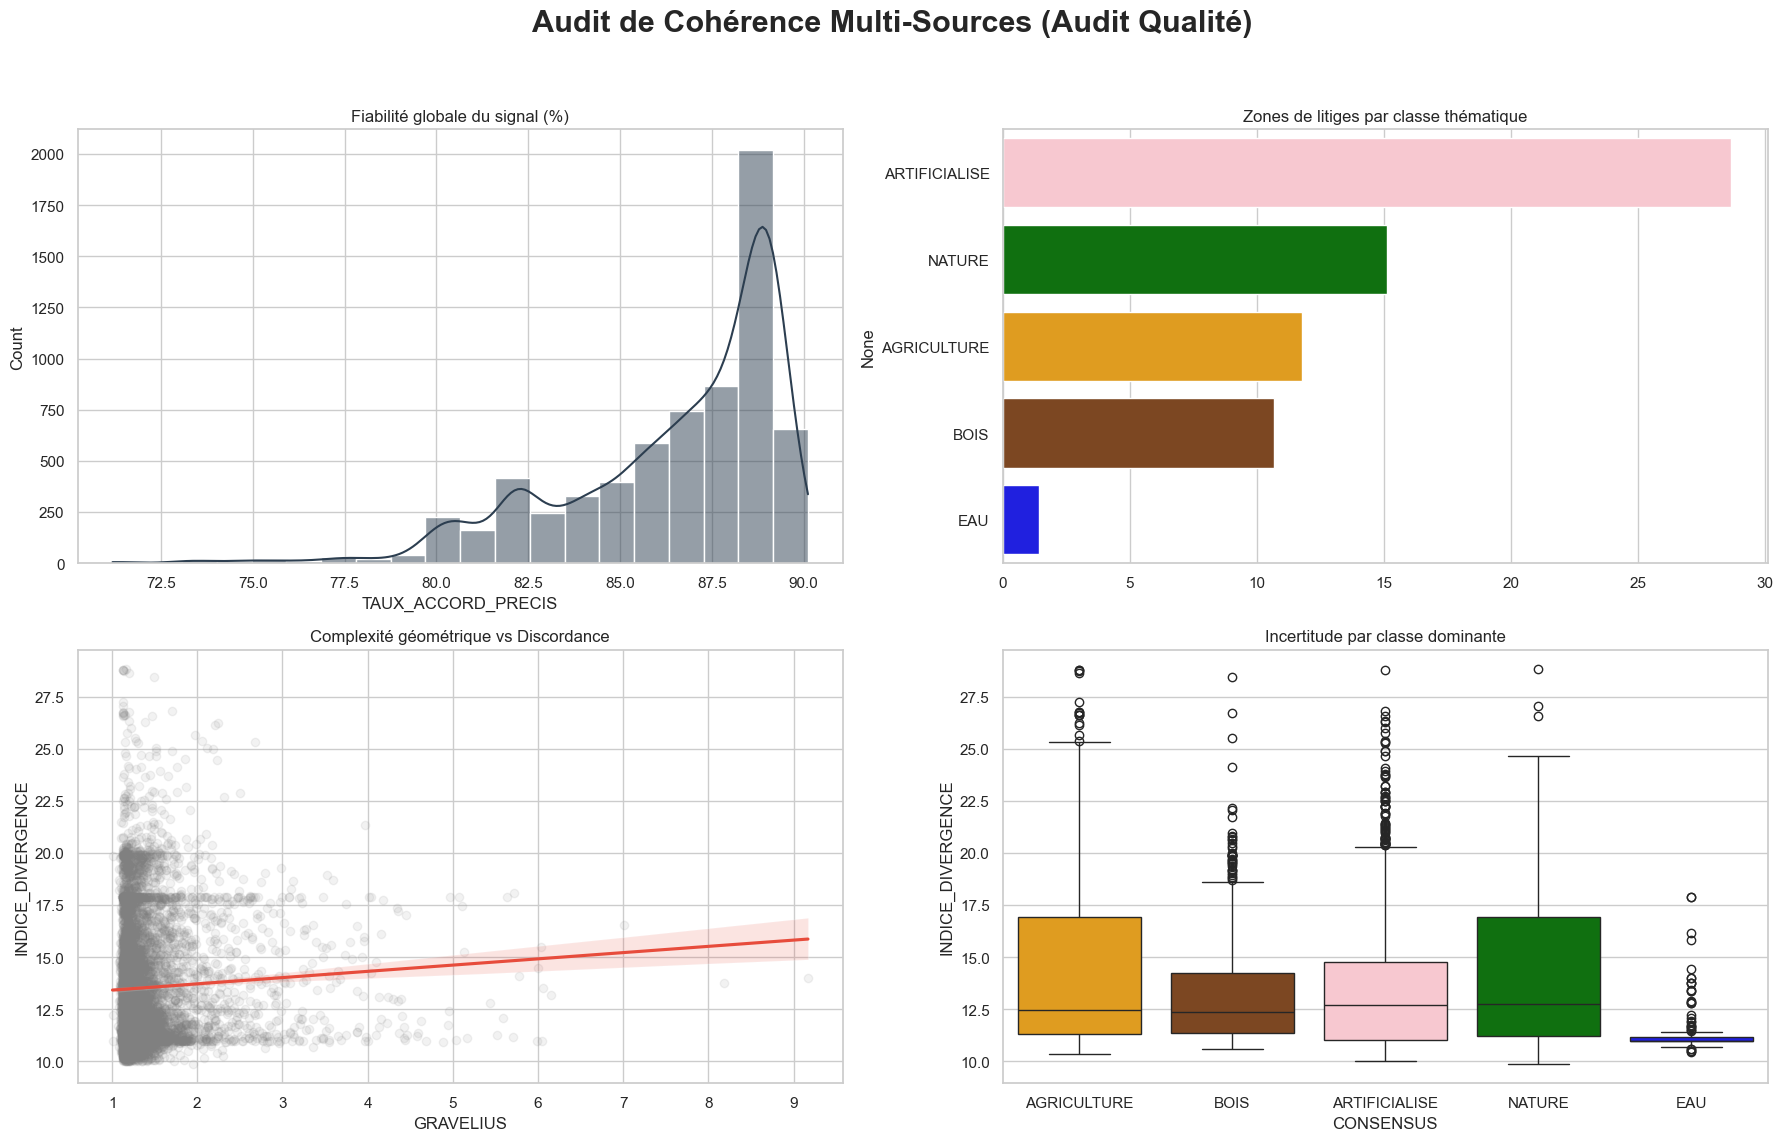

In [7]:
# =============================================================================
# MODULE DE SYNTHÈSE : ANALYSE DE LA COHÉRENCE THÉMATIQUE
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

print("\n>>> DÉMARRAGE DE L'ANALYSE DE COHÉRENCE THÉMATIQUE (2021)...")

# --- 1. CONFIGURATION ET CHARGEMENT DES DONNÉES ---
COLOR_MAPPING = {
    'ARTIFICIALISE': '#ffc0cb', 'AGRICULTURE': '#ffa500', 'BOIS': '#8b4513',
    'NATURE': '#008000', 'EAU': '#0000ff', 'AUTRE': '#ffffff'
}

classes_reelles = ["ARTIFICIALISE", "AGRICULTURE", "NATURE", "BOIS", "EAU"]
classes_full = classes_reelles + ["AUTRE"]

sources = ['OSO', 'RPG', 'TOPO', 'COSIA', 'FORET']

dfs_list = []

for src in sources:
    suffixe = f"DALLE_{DALLE_SELECTION}" if DALLE_SELECTION else "FULL"
    
    # Gestion des noms de fichiers selon tes modules
    if src == 'TOPO': prefix = 'BDTOPO_2021'
    elif src == 'FORET': prefix = 'FORET_2017' # Ton Module 3 génère du 2017
    else: prefix = f"{src}_2021"
    
    file_name = f"{prefix}_{suffixe}.csv"
    path = DIR_SORTIE / file_name
    
    if path.exists():
        # PROTECTION : Lecture forcée du PL en string pour éviter la perte des zéros
        df = pd.read_csv(path, sep=';', dtype={'PL': str})
        
        # Nettoyage des identifiants pour garantir la fusion
        df['PL'] = df['PL'].str.strip().str.zfill(11)
        df = df.set_index('PL')
        
        # Extraction des colonnes de ratio (%)
        cols_extract = [f"{c}_%" for c in classes_full if f"{c}_%" in df.columns]
        df = df[cols_extract]
        
        # Renommage pour la fusion : NATURE_% -> NATURE_FORET
        df.columns = [c.replace('_%', f'_{src}') for c in cols_extract]
        dfs_list.append(df)
        print(f"   + Source chargée : {src}")
    else:
        print(f"   ! Source absente : {src} (attendu: {file_name})")

if not dfs_list:
    raise FileNotFoundError("Aucune donnée source n'a pu être chargée.")

# Fusion de tous les avis d'experts
df_total = pd.concat(dfs_list, axis=1).dropna()

# --- 2. CALCUL DE LA DISCORDANCE (ÉCART-TYPE ENTRE EXPERTS) ---
for cl in classes_reelles:
    # On récupère toutes les colonnes liées à la classe (ex: BOIS_OSO, BOIS_FORET...)
    cols_cl = [f"{cl}_{src}" for src in sources if f"{cl}_{src}" in df_total.columns]
    
    if len(cols_cl) > 1:
        # La divergence est l'écart-type : plus il est haut, moins les sources sont d'accord
        df_total[f"DIV_{cl}"] = df_total[cols_cl].std(axis=1)
    else:
        df_total[f"DIV_{cl}"] = 0.0

# Indice Global et Taux d'Accord
div_cols = [f"DIV_{cl}" for cl in classes_reelles]
df_total['INDICE_DIVERGENCE'] = df_total[div_cols].mean(axis=1)
df_total['TAUX_ACCORD_PRECIS'] = (100 - df_total['INDICE_DIVERGENCE']).clip(0, 100)

# Consensus (basé sur OSO ou la première source disponible)
df_total['CONSENSUS'] = df_total[[f"{c}_OSO" for c in classes_reelles if f"{c}_OSO" in df_total.columns]].idxmax(axis=1).str.replace('_OSO', '')

# --- 3. MORPHOLOGIE ET FUSION FINALE ---
gdf_morpho = gdf_parcelles[['PL', 'geometry']].copy()
gdf_morpho['PL'] = gdf_morpho['PL'].astype(str).str.strip().str.zfill(11)
gdf_morpho['SURFACE'] = gdf_morpho.geometry.area
gdf_morpho['GRAVELIUS'] = gdf_morpho.geometry.length / (2 * np.sqrt(np.pi * gdf_morpho['SURFACE']))

df_final = df_total.merge(gdf_morpho[['PL', 'SURFACE', 'GRAVELIUS']], on='PL')

# --- 4. VISUALISATION AVEC TES COULEURS ---
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(f"Audit de Cohérence Multi-Sources (Audit Qualité)", fontsize=22, fontweight='bold')

# 1. Distribution Accord
sns.histplot(df_final['TAUX_ACCORD_PRECIS'], bins=20, kde=True, ax=axes[0, 0], color="#2c3e50")
axes[0, 0].set_title("Fiabilité globale du signal (%)")

# 2. Divergence par classe (COLOR_MAPPING utilisé ici)
mean_div = df_total[div_cols].mean().sort_values(ascending=False)
mean_div.index = [i.replace('DIV_', '') for i in mean_div.index]
sns.barplot(x=mean_div.values, y=mean_div.index, ax=axes[0, 1], palette=COLOR_MAPPING, hue=mean_div.index, legend=False)
axes[0, 1].set_title("Zones de litiges par classe thématique")

# 3. Forme vs Discordance
sns.regplot(x='GRAVELIUS', y='INDICE_DIVERGENCE', data=df_final, ax=axes[1, 0], 
            scatter_kws={'alpha':0.1, 'color':'gray'}, line_kws={'color':'#e74c3c'})
axes[1, 0].set_title("Complexité géométrique vs Discordance")

# 4. Boxplot par Consensus (COLOR_MAPPING utilisé ici)
sns.boxplot(x='CONSENSUS', y='INDICE_DIVERGENCE', data=df_final, ax=axes[1, 1], palette=COLOR_MAPPING, hue='CONSENSUS', legend=False)
axes[1, 1].set_title("Incertitude par classe dominante")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(DIR_SORTIE / "ANALYSE_COHERENCE_COMPLETE.png", dpi=300)

# --- 5. EXPORT ---
out_suffixe = f"DALLE_{DALLE_SELECTION}" if DALLE_SELECTION else "FULL"
df_final.to_csv(DIR_SORTIE / f"SYNTHESE_COHERENCE_FINALE_{out_suffixe}.csv", sep=';', index=False)

print(f">>> SYNTHÈSE TERMINÉE. Moyenne d'accord : {df_final['TAUX_ACCORD_PRECIS'].mean():.2f}%")

# Rapport de synthèse : Cohérence thématique et morphologique (2021)

Ce rapport présente les résultats du croisement des référentiels d'occupation du sol (**OSO, RPG, BD TOPO, BD FORET, COSIA**).

## L'Analyse surfacique : Un Objectif de validation de cohérence
L'analyse surfacique n'est pas seulement une mesure de précision, elle constitue le test de validation indispensable du système multi-sources.
* **Objectif de cohérence** : L'enjeu premier est de vérifier si des sources produites de manières hétérogènes convergent vers une réalité physique commune.
* **Validation des données** : Une forte corrélation surfacique permet de valider la fiabilité des données sources avant toute simplification.

## 1. Analyse des résultats : Cohérence et divergence
L'étude des indicateurs de surface révèle une base de données robuste, mais dont la précision varie selon les thématiques :

* **Distribution de la cohérence** : Le taux d'accord corrigé est concentré entre **85% et 90%**. Cela démontre une forte convergence des sources expertes sur la majeure partie du territoire.
* **Hiérarchie de la discordance** : La classe **ARTIFICIALISE** présente la divergence moyenne la plus élevée (proche de 30). Cela s'explique par les différences de définitions sémantiques (ex: inclusion ou non des jardins privés et dépendances) entre les sources.
* **Stabilité par classe** : La classe **EAU** affiche une quasi-unanimité avec une divergence minimale, car ses contours géométriques sont nets et peu sujets à interprétation.

## 2. Justification géométrique : L'impact de la morphologie
Le graphique **"Morphologie (Gravelius) vs Discordance"** apporte une preuve mathématique aux erreurs observées :

* **Corrélation positive** : On observe une droite de régression ascendante. Plus l'indice de Gravelius augmente (parcelles complexes, allongées ou découpées), plus l'indice de divergence augmente.
* **Effet de bordure** : Les parcelles complexes possèdent un périmètre plus important pour une même surface. Cela multiplie les zones de contact et les risques de décalage géométrique, générant mécaniquement de la discordance thématique.

## 3. Pourquoi la dominance est-elle obligatoire ?
Malgré la précision du surfacique, le passage à une **approche par dominance** (classe majoritaire) est une obligation technique absolue pour l'analyse multi-dates (2018-2024).

### A. Élimination du "Bruit" statistique et géométrique
En analyse surfacique, une variation infime de surface (due à un décalage d'un mètre entre deux capteurs) est interprétée comme un changement de sol. La dominance permet de **stabiliser l'étiquette** thématique et d'ignorer ce "bruit" pour ne retenir que les mutations structurelles.

### B. Fiabilité du suivi temporel
Il est techniquement plus robuste de comparer des étiquettes franches (ex: "Agriculture" devient "Artificialisé") que de comparer des pourcentages qui fluctuent sans cesse à cause de l'imprécision native des images satellites.

## 4. Comparaison des deux approches

| Indicateur | Analyse Surfacique | Analyse par Dominance |
| :--- | :--- | :--- |
| **Objectif** | **Vérification de la cohérence entre sources.** | **Stabilité pour le suivi temporel.** |
| **Sensibilité** | Haute (identifie les micro-écarts). | Basse (filtre les erreurs de mesure). |
| **Décision** | Nuancée (pourcentages). | Binaire (étiquette unique). |
| **Usage** | Diagnostic de qualité et jauge de fiabilité. | Production de matrices de transition. |

**Conclusion** : L'approche surfacique sert exclusivement à valider la cohérence des sources à un instant T. En revanche, pour l'analyse temporelle, le passage à la dominance est une **obligation technique absolue**. Il est **matériellement impossible** de suivre l'évolution du territoire via les pourcentages de surface : les micro-décalages géométriques entre millésimes pollueraient les résultats en créant des faux changements systématiques. La dominance est l'unique solution pour s'affranchir de ce bruit de mesure et obtenir une information décisionnelle stable, permettant enfin de distinguer les véritables mutations foncières des simples imprécisions techniques.